#### Scenario
A healthcare provider initiated an attrition analysis. They wish to know their current attrition rate and, if the rate is greater than ten percent, what are the contributing factors and potential solutions.

#### Problem Statement
How can we increase employee retention while minimizing costs?

In [1]:
import decimal
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Tuple, Callable
from math import ceil, sqrt, modf

import pandas as pd
import seaborn as sns
from pandasql import sqldf
from statistics import median, stdev
from statsmodels.stats.weightstats import ztest

import utils

# Import file
filename = 'data/healthcare_attrition.csv'
raw_df = pd.read_csv(Path(utils.root(), filename), sep=',')

### Samples
talk about how you got the sizes and got the sample. Used sample size calculator to determine sample size.

In [2]:
sample_size = 100
def samples(*, is_employed: bool) -> List:
    population = None
    num_of_samples = 21
    
    if is_employed:
        population = raw_df.query("Attrition == 'No'")
    else:
        population = raw_df.query("Attrition == 'Yes'")
    
    lst = []
    for x in range(num_of_samples):
        sample_ = population.sample(n=sample_size).reset_index(drop=True)
        lst.append(sample_)
    return lst

## Attrition Rate

In [3]:
# ATTRITION RATE
attrition_sr = raw_df['Attrition'] # isolating Attrition column

attrition_count = attrition_sr.value_counts()['Yes']
num_of_employees = attrition_sr.count()

attrition_rate_percentage = round(attrition_count / num_of_employees, 2) * 100
print(f'The attrition rate is approximately {attrition_rate_percentage}%')
# TODO: Double check attrition rate

The attrition rate is approximately 12.0%


## Attrition by Age
***
$H_{0}: \bar{x}_{1} = \bar{x}_{2}$ <br>
$H_{a}: \bar{x}_{1} \ne \bar{x}_{2}$


CHART
---------------


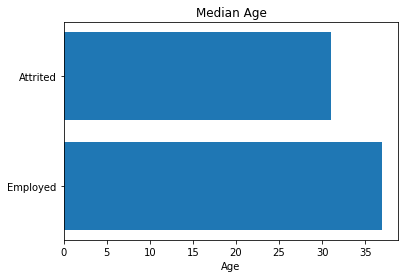


SUMMARY
---------------
pval          0.000
cohens_d      0.705
ci_lower     22.000
ci_upper     40.000
empl_p        0.660
attr_p        0.730
empl_mean    37.000
attr_mean    31.000
dtype: float64


In [4]:
def age_test(empl_sample: pd.DataFrame, attr_sample: pd.DataFrame) -> pd.DataFrame:
    empl_age_sample = empl_sample['Age']
    attr_age_sample = attr_sample['Age']
    
    pval = utils.pval_unequal_stdev(empl_age_sample, attr_age_sample)
    cohens_d = utils.cohens_d(empl_age_sample, attr_age_sample)
    
    ci, empl_p, attr_p = utils.ci(empl_age_sample, attr_age_sample)
    empl_mean, attr_mean = utils.means(empl_age_sample, attr_age_sample)
    
    dict_ = {
        'pval': [pval],
        'cohens_d': [cohens_d],
        'ci_lower': [ci[0]],
        'ci_upper': [ci[1]],
        'empl_p': [empl_p],
        'attr_p': [attr_p],
        'empl_age_mean': [empl_mean],
        'attr_age_mean': [attr_mean]
    }
    return pd.DataFrame(dict_)


def plot_mean_ages(empl_age: float, attr_age: float) -> None:
    print(utils.create_title('chart'))
    y = ['Employed', 'Attrited']
    x = [empl_age, attr_age]

    plt.barh(y, x)
    plt.xlabel("Age")
    plt.title("Median Age")
    plt.show()


results = utils.run_test(samples(is_employed=True), samples(is_employed=False), colname='Age', need_mean=True)
results = utils.median_(results)
plot_mean_ages(results['empl_mean'], results['attr_mean'])

print(utils.create_title('summary'))
print(results)
# TODO: use seaborn to plot median age

## Attrition by Frequent Travel
***
Write here about how you came to your conclusion, how the data is statistically relevant, and the effect size. This would include formulas for the ztest, pooled proportion, etc. Talk about how you tested for significance (and the formulas used) then tested for effect size.

Cohen H indicates small effect. h = .2: small effect, h = .5: medium effect, h = .8: large effect

$H_{0}: \hat{p}_{1} = \hat{p}_{2}$ <br>
$H_{a}: \hat{p}_{1} \ne \hat{p}_{2}$

pval         0.063
cohen's h    0.265
empl_p       0.170
attr_p       0.270
dtype: float64


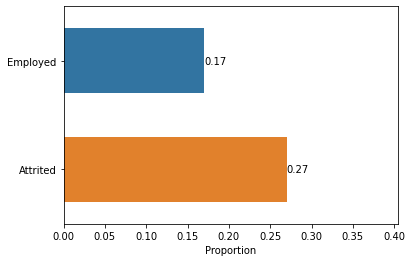

In [5]:
def freq_travel_test(empl_sample: pd.DataFrame, attr_sample: pd.DataFrame) -> None:
    
    def _freq_trav_obs(sample: pd.DataFrame) -> int:
        sr = sample['BusinessTravel']
        freq_sr = sr[sr == 'Travel_Frequently']
        return freq_sr.count()
    
    
    empl_obs = _freq_trav_obs(empl_sample)
    attr_obs = _freq_trav_obs(attr_sample)
    
    empl_n = empl_sample.shape[0]
    attr_n = attr_sample.shape[0]
    
    empl_p = empl_obs / empl_n
    attr_p = attr_obs / attr_n
    

    dict_ = {
        'pval': [utils.proportions_pval(x1=empl_obs, x2=attr_obs, n1=empl_n, n2=attr_n)],
        "cohen's h": [utils.cohen_h(empl_p, attr_p)],
        'empl_p': [empl_p],
        'attr_p': [attr_p]
    }
    return pd.DataFrame(dict_)


def plot_freq_travel_proportions(freq_trav_results: pd.Series) -> None:
    empl_p = freq_trav_results.at['empl_p']
    attr_p = freq_trav_results.at['attr_p']
    
    data = {'Sample': ['Employed', 'Attrited'], 'Proportion': [empl_p, attr_p]}
    proportions_df = pd.DataFrame(data)
    
    plot = sns.barplot(data=proportions_df, x='Proportion', y='Sample', orient='h', width=0.6)
    for container in plot.containers:
        plot.bar_label(container)
        
    plot.set(ylabel=None)
    
    xlim = empl_p * 1.5 if empl_p > attr_p else attr_p * 1.5
    plot.set_xlim(0, xlim)
    plt.show()


results = utils.run_test(samples(is_employed=True), samples(is_employed=False), func=freq_travel_test)
results = utils.median_(results)

print(results)
plot_freq_travel_proportions(results)

## Attrition by Department


PROPORTIONS
---------------
  Group  Department  Proportion
0  Attr  Cardiology        0.37
1  Attr   Maternity        0.50
2  Attr   Neurology        0.14
3  Empl  Cardiology        0.29
4  Empl   Maternity        0.50
5  Empl   Neurology        0.20 


SIGNIFICANCE
---------------
Cardiology pval: 0.921
Cardiology Cohen's h: 0.17

Maternity pval: 1.0
Maternity Cohen's h: 0.0

Neurology pval: 0.918
Neurology Cohen's h: 0.16


CHART
---------------


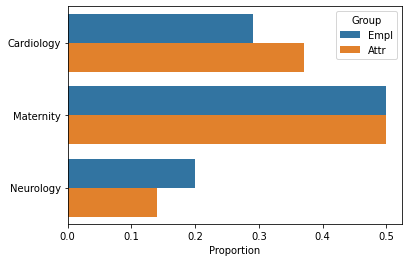

In [6]:
group_str = 'Group'
dept_str = 'Department'
prop_str = 'Proportion'


def gather_dept_proportions(empl_sample: pd.DataFrame, attr_sample: pd.DataFrame) -> pd.DataFrame:
    
    def _calc_proportions(sample: pd.DataFrame, *, is_empl_sample: bool) -> pd.DataFrame:
        '''
        Counts observations and calculates proportions by department. 

        @param:
            sample (pd.DataFrame): independent sample

        @returns:
            pd.DataFrame: a DataFrame with proportions of observations. Columns are Group, Department, Proportion.
        '''
        dept_sr = sample[dept_str]
        
        values_df = dept_sr.value_counts().to_frame().reset_index()
        values_df = values_df.rename(columns={dept_str: 'Count', 'index': dept_str})

        col1 = group_str
        col2 = dept_str
        col3 = prop_str
        df = pd.DataFrame(columns=[col1, col2, col3])
        
        n = sample.shape[0]
        group = 'Empl' if is_empl_sample else 'Attr'
        for row in values_df.itertuples():
            proportion = row.Count / n
            
            new_row = {
                col1: [group], 
                col2: [row.Department], 
                col3: [proportion]
            }
            df = pd.concat([df, pd.DataFrame(new_row)])
        return df
    
    
    empl_df = _calc_proportions(empl_sample, is_empl_sample=True)
    attr_df = _calc_proportions(attr_sample, is_empl_sample=False)
    
    return pd.concat([empl_df, attr_df]).reset_index(drop=True)


def dept_proportions(func: Callable, empl_samples: List, attr_samples: List) -> None:
    p_df = utils.run_test(empl_samples, attr_samples, func=func)
    p_df = p_df.groupby([group_str, dept_str], as_index=False).median()
    return p_df
    
    
def test_dept_significance(results_df: pd.DataFrame, n: int) -> None:
    departments = results_df[dept_str].drop_duplicates()
    
    print(utils.create_title('significance'))
    
    for dept in departments:
        p = results_df[results_df[dept_str] == dept][prop_str].tolist()
        
        pval = utils.proportions_pval(x1=p[0], n1=n, x2=p[1], n2=n)
        h = utils.cohen_h(p[0], p[1])
        
        print(f'{dept} pval: {round(pval, 3)}')
        print(f'{dept} Cohen\'s h: {round(h, 3)}\n')

        
def plot_dept_proportions(results_df: pd.DataFrame) -> None:
    print(utils.create_title('chart'))
    
    order = ['Empl', 'Attr']
    plot = sns.barplot(data=results_df, x=prop_str, y=dept_str, hue=group_str,
                       orient='h', hue_order=order)
    plot.set(ylabel=None)
    plt.show()
    
    
dept_proportions_df = dept_proportions(gather_dept_proportions, samples(is_employed=True), samples(is_employed=False))

print(utils.create_title('proportions'))
print(dept_proportions_df, '\n')

test_dept_significance(dept_proportions_df, sample_size)
plot_dept_proportions(dept_proportions_df)

## Attrition by Commute

In [7]:
commute_df = utils.run_test(samples(is_employed=True),
                            samples(is_employed=False),
                            need_mean=True,
                            colname='DistanceFromHome')


print(utils.median_(commute_df))
# Todo: plot

pval          0.027
cohens_d      0.312
ci_lower      1.000
ci_upper     17.000
empl_p        0.820
attr_p        0.700
empl_mean     9.000
attr_mean    11.000
dtype: float64
